# **Data Collection**

In [ ]:
!pip install pandas==<1.5.1>
!pip install pickle


/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `pip install pandas==<1.5.1>'
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
!git clone https://github.com/Accuser907/FineFake.git /content/FineFake_repo



Cloning into '/content/FineFake_repo'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 221 (delta 41), reused 159 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (221/221), 102.72 KiB | 1.97 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = "/content/drive/My Drive/FineFake.zip"
extract_folder = "/content/FineFake_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Files extracted to:", extract_folder)


Files extracted to: /content/FineFake_data


In [ ]:
!pip install langdetect
!pip install flair
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=1fab2ef8822609de91d01a4dc0a5e5a03d275bf555f1d643910e4e8d0e8f0eae
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from langdetect import detect
from flair.nn import Classifier
from flair.data import Sentence
from torchvision import transforms
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, CLIPProcessor, CLIPModel
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# **Data Exploration**

In [ ]:
pickle_path = "/content/FineFake_data/FineFake.pkl"


with open(pickle_path, "rb") as f:
    data_df = pd.read_pickle(f)

print(data_df.info())
print(data_df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 16909 entries, 0 to 16908
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 16909 non-null  object
 1   image_path           16909 non-null  object
 2   entity_id            16909 non-null  object
 3   topic                16909 non-null  object
 4   fine-grained label   16909 non-null  int64 
 5   label                16909 non-null  int64 
 6   knowledge_embedding  16909 non-null  object
 7   description          16909 non-null  object
 8   relation             16909 non-null  object
 9   platform             16909 non-null  object
 10  author               8739 non-null   object
 11  date                 12126 non-null  object
 12  comment              4969 non-null   object
dtypes: int64(2), object(11)
memory usage: 1.8+ MB
None
                                                text             image_path  \
0  CDCs Abortion Surveilla

In [ ]:
image_folder = "/content/FineFake_data/Image"

print("Folders inside Image directory:", os.listdir(image_folder))


Folders inside Image directory: ['washingtonpost', 'twitter', 'historyanecdotes', 'photoshopbattles', 'nytimes', 'cnn', 'cdc_gov', 'snope', 'oldphotosinreallife', 'reddit', 'HeresAFunFact', 'misleadingthumbnails', 'apnews', 'conspiracy']


In [ ]:
image_folder = "/content/FineFake_data/Image"


for category in os.listdir(image_folder):
    category_path = os.path.join(image_folder, category)
    if os.path.isdir(category_path):
        print(f"Category: {category}")
        print(os.listdir(category_path)[:5])
        break

Category: washingtonpost
['1552.jpeg', '470.jpeg', '591.jpeg', '1259.jpeg', '1352.jpeg']


In [ ]:
print(data_df["image_path"].sample(10))


13249                 Image/snope/15863.jpeg
2511               Image/conspiracy/627.jpeg
12762                   Image/snope/9771.png
633                        Image/cnn/78.jpeg
11116              Image/conspiracy/2449.png
2083     Image/misleadingthumbnails/106.jpeg
14448         Image/photoshopbattles/70.jpeg
4026       Image/oldphotosinreallife/43.jpeg
14137                 Image/nytimes/1366.png
10756                Image/nytimes/1058.jpeg
Name: image_path, dtype: object


In [ ]:
expected_columns = [
    "text", "image_path", "entity_id", "topic", "label", "fine-grained label",
    "knowledge_embedding", "description", "relation", "platform",
    "author", "date", "comment"
]
print("Columns Match:", set(expected_columns) == set(data_df.columns))


Columns Match: True


In [ ]:
print(data_df["topic"].value_counts())
print(data_df["platform"].value_counts())


topic
Politics         5727
Society          3939
Entertainment    3699
Conflict         1718
Business         1003
Health            710
Uncategorized     113
Name: count, dtype: int64
platform
snope             7556
reddit            4048
cnn               2310
washingtonpost    1041
twitter            952
apnews             734
cdc_gov            268
Name: count, dtype: int64


# **Data Preprocessing**

In [ ]:
print("Missing Values:\n", data_df.isnull().sum())

Missing Values:
 text                       0
image_path                 0
entity_id                  0
topic                      0
fine-grained label         0
label                      0
knowledge_embedding        0
description                0
relation                   0
platform                   0
author                  8170
date                    4783
comment                11940
dtype: int64


In [ ]:
missing_values = data_df.isnull().sum()
print("Missing Values per Column:\n", missing_values)

missing_percentage = (missing_values / len(data_df)) * 100
print("\nMissing Values Percentage:\n", missing_percentage)

Missing Values per Column:
 text                       0
image_path                 0
entity_id                  0
topic                      0
fine-grained label         0
label                      0
knowledge_embedding        0
description                0
relation                   0
platform                   0
author                  8170
date                    4783
comment                11940
dtype: int64

Missing Values Percentage:
 text                    0.000000
image_path              0.000000
entity_id               0.000000
topic                   0.000000
fine-grained label      0.000000
label                   0.000000
knowledge_embedding     0.000000
description             0.000000
relation                0.000000
platform                0.000000
author                 48.317464
date                   28.286711
comment                70.613283
dtype: float64


In [ ]:
print("Before dropping:", data_df.shape)


Before dropping: (16909, 13)


In [ ]:
data_df = data_df.drop_duplicates(subset=["text"])

In [ ]:
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

data_df = data_df[data_df["text"].apply(is_english)]

In [ ]:
data_df = data_df[data_df["text"].str.len() > 30]

In [ ]:
data_df["author"] = data_df["author"].fillna("Anonymous")
data_df["date"] = data_df["date"].fillna("Unknown")


In [ ]:
image_folder = "/content/FineFake_data/Image"

In [ ]:
def fix_image_path(img_path):
    img_path = img_path.replace("Image/", f"{image_folder}/")
    return img_path if os.path.exists(img_path) else "no_image.jpg"

data_df["image_path"] = data_df["image_path"].apply(fix_image_path)

In [ ]:
print("Final dataset shape:", data_df.shape)


Final dataset shape: (14696, 13)


In [ ]:
print(data_df["label"].value_counts())


label
0    7460
1    7236
Name: count, dtype: int64


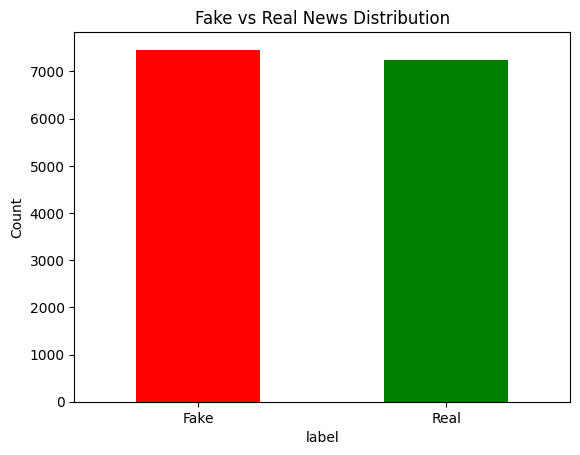

In [ ]:
import matplotlib.pyplot as plt

data_df["label"].value_counts().plot(kind="bar", color=["red", "green"])
plt.title("Fake vs Real News Distribution")
plt.xticks(ticks=[0, 1], labels=["Fake", "Real"], rotation=0)
plt.ylabel("Count")
plt.show()


In [ ]:

fake_news = data_df[data_df["label"] == 0]
real_news = data_df[data_df["label"] == 1]
fake_news_sampled = resample(fake_news, replace=False, n_samples=len(real_news), random_state=42)
balanced_df = pd.concat([fake_news_sampled, real_news])

In [ ]:
print(data_df["fine-grained label"].value_counts())


fine-grained label
0    7236
3    3394
4    1402
2    1245
1    1146
5     273
Name: count, dtype: int64


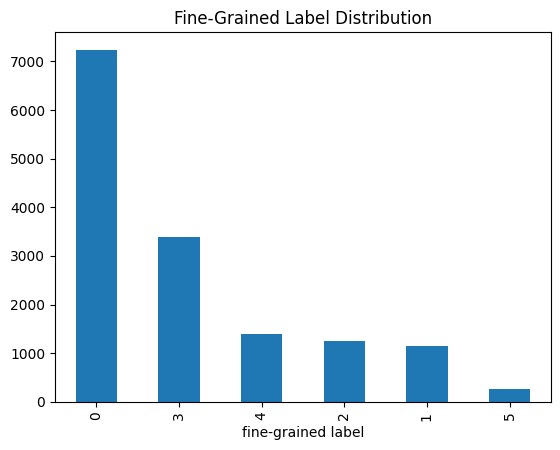

In [ ]:
data_df["fine-grained label"].value_counts().plot(kind="bar")
plt.title("Fine-Grained Label Distribution")
plt.show()


In [ ]:
train_val_df, test_df = train_test_split(balanced_df, test_size=0.15, random_state=42, stratify=balanced_df["label"])
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, random_state=42, stratify=train_val_df["label"])

# **Model Selection and Feature Engineering**

In [ ]:
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

class GradientReversal(nn.Module):
    def __init__(self, lambda_=1.0):
        super().__init__()
        self.lambda_ = lambda_
    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)


In [ ]:
class FineFakeDataset(Dataset):
    """
    Dataset for FineFake.
    Returns:
      - input_ids, attention_mask (from BERT tokenizer)
      - image_features (from CLIP processor)
      - fine-grained label (0-5)
      - domain label (0 for social media, 1 for official news)
    """
    def __init__(self, data_df, train=True, tokenizer_name='bert-base-uncased', max_length=256):
        self.data_df = data_df.reset_index(drop=True)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.max_length = max_length
        self.train = train

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        row = self.data_df.iloc[idx]
        text = row['text']
        image_path = row['image_path']

        domain_label = 0 if row['platform'].lower() in ['twitter', 'reddit'] else 1


        text_encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        input_ids = text_encoding['input_ids'].squeeze(0)
        attention_mask = text_encoding['attention_mask'].squeeze(0)


        try:
            image = Image.open(image_path).convert("RGB")
            image_inputs = self.clip_processor(images=image, return_tensors="pt")
            image_features = image_inputs["pixel_values"].squeeze(0)
        except Exception:
            image_features = torch.zeros((3, 224, 224))

        label = torch.tensor(row['fine-grained label'], dtype=torch.long)
        domain_label = torch.tensor(domain_label, dtype=torch.float32)
        return input_ids, attention_mask, image_features, label, domain_label


In [ ]:
class FineFakeDataModule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, batch_size=32, tokenizer_name='bert-base-uncased', max_length=256):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.tokenizer_name = tokenizer_name
        self.max_length = max_length

    def setup(self, stage=None):
        self.train_dataset = FineFakeDataset(self.train_df, train=True,
                                              tokenizer_name=self.tokenizer_name,
                                              max_length=self.max_length)
        self.val_dataset = FineFakeDataset(self.val_df, train=False,
                                            tokenizer_name=self.tokenizer_name,
                                            max_length=self.max_length)
        self.test_dataset = FineFakeDataset(self.test_df, train=False,
                                             tokenizer_name=self.tokenizer_name,
                                             max_length=self.max_length)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)

In [ ]:
class KEANModel(pl.LightningModule):
    def __init__(self, text_model='bert-base-uncased', clip_model='openai/clip-vit-base-patch32',
                 num_classes=6, learning_rate=2e-5, data_df=None, lambda_grl=1.0):
        super().__init__()
        self.save_hyperparameters(ignore=['data_df'])
        self.learning_rate = learning_rate
        self.domain_loss_fn = nn.BCELoss()


        self.text_encoder = BertModel.from_pretrained(text_model)
        self.text_fc = nn.Linear(768, 512)


        self.image_encoder = CLIPModel.from_pretrained(clip_model)
        self.image_fc = nn.Linear(512, 512)


        self.fusion_fc = nn.Linear(1024, 128)
        self.classifier = nn.Linear(128, num_classes)


        self.grl = GradientReversal(lambda_=lambda_grl)
        self.domain_discriminator = nn.Sequential(
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )


        import numpy as np
        if data_df is not None:
            weights = compute_class_weight('balanced', classes=np.array([0, 1, 2, 3, 4, 5]),
                                       y=data_df['fine-grained label'])
            class_weights = torch.tensor(weights, dtype=torch.float32)
            self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.criterion = nn.CrossEntropyLoss()



    def forward(self, input_ids, attention_mask, images):
        text_out = self.text_encoder(input_ids, attention_mask=attention_mask)
        text_features = self.text_fc(text_out.last_hidden_state[:, 0, :])
        image_features = self.image_encoder.get_image_features(pixel_values=images)
        image_features = self.image_fc(image_features)
        fused_features = torch.cat((text_features, image_features), dim=1)
        x = self.fusion_fc(fused_features)
        class_output = self.classifier(x)
        reversed_features = self.grl(fused_features)
        domain_output = self.domain_discriminator(reversed_features)
        return class_output, domain_output

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, images, labels, domain_labels = batch
        class_output, domain_output = self(input_ids, attention_mask, images)
        class_loss = self.criterion(class_output, labels)
        domain_loss = self.domain_loss_fn(domain_output, domain_labels.float().unsqueeze(1))
        total_loss = class_loss + 0.1 * domain_loss
        self.log('train_loss', total_loss, prog_bar=True, on_step=True, on_epoch=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, images, labels, domain_labels = batch
        class_output, _ = self(input_ids, attention_mask, images)
        val_loss = self.criterion(class_output, labels)
        preds = torch.argmax(class_output, dim=1)
        acc = (preds == labels).float().mean()
        self.log('val_loss', val_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        input_ids, attention_mask, images, labels, domain_labels = batch
        class_output, _ = self(input_ids, attention_mask, images)
        test_loss = self.criterion(class_output, labels)
        preds = torch.argmax(class_output, dim=1)
        acc = (preds == labels).float().mean()
        self.log('test_loss', test_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        return test_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}}

# **Model Training and Evaluation**

In [ ]:
if __name__ == "__main__":

    data_module = FineFakeDataModule(train_df=train_df, val_df=val_df, test_df=test_df, batch_size=32)


    model = KEANModel(text_model='bert-base-uncased',
                      clip_model='openai/clip-vit-base-patch32',
                      num_classes=6,
                      data_df=train_df,
                      lambda_grl=1.0,
                      learning_rate=2e-5)


    logger = TensorBoardLogger("tb_logs", name="KEANModel")
    checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, filename="kean-{epoch:02d}-{val_loss:.2f}")
    early_stop_callback = EarlyStopping(monitor="val_loss", patience=4, mode="min")
    lr_monitor = LearningRateMonitor(logging_interval="epoch")

trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else 0,
    logger=logger,
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    deterministic=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
    trainer.fit(model, datamodule=data_module)

    test_results = trainer.test(model, datamodule=data_module)
    print("Test Results:", test_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type             | Params | Mode 
------------------------------------------------------------------
0 | domain_loss_fn       | BCELoss          | 0      | train
1 | text_encoder         | BertModel        | 109 M  | eval 
2 | text_fc              | Linear           | 393 K  | train
3 | image_encoder        | CLIPModel        | 151 M  | eval 
4 | image_fc             | Linear           | 262 K  | train
5 | fusion_fc            | Linear           | 131 K  | train
6 | classifier           | Linear           | 774    | train
7 | grl                  | GradientReversal | 0      | train
8 | domain_discriminator | Sequential       | 131 K  | train
9 | criterion            | CrossEntropyLoss | 0      | train
------------------------------------------------------------------
261 M     Trainable params
0         Non-trainable params
261 M 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6259788274765015     │
│         test_loss         │    2.5331709384918213     │
└───────────────────────────┴───────────────────────────┘

Test Results: [{'test_loss': 2.5331709384918213, 'test_acc': 0.6259788274765015}]


In [ ]:
model.eval()
all_preds = []
all_labels = []
for batch in data_module.test_dataloader():
    input_ids, attention_mask, images, labels, domain_labels = batch
    input_ids = input_ids.to(model.device)
    attention_mask = attention_mask.to(model.device)
    images = images.to(model.device)
    labels = labels.to(model.device)
    with torch.no_grad():
        class_output, _ = model(input_ids, attention_mask, images)
    preds = torch.argmax(class_output, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="macro")
recall = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")
cm = confusion_matrix(all_labels, all_preds)

print(f"✅ Test Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print("✅ Confusion Matrix:")
print(cm)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


✅ Test Accuracy: 0.6260
✅ Precision: 0.4946
✅ Recall: 0.4565
✅ F1 Score: 0.4685
✅ Confusion Matrix:
[[798  17  35 184  38  13]
 [ 75  72   5  16   9   0]
 [ 49  10  49  74   4   2]
 [111   6  46 314  13   1]
 [ 33   5   4  24 124   3]
 [ 24   5   2   3   1   2]]
